In [28]:
!pip install jovian --upgrade --quiet

In [3]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
#Importing dataset
! git clone "https://github.com/ardamavi/Sign-Language-Digits-Dataset.git"

Cloning into 'Sign-Language-Digits-Dataset'...
remote: Enumerating objects: 2089, done.
remote: Total 2089 (delta 0), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2089/2089), 15.07 MiB | 20.25 MiB/s, done.
Resolving deltas: 100% (658/658), done.


In [4]:
data_dir = './Sign-Language-Digits-Dataset'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/Dataset")
print(classes)

['README.md', 'Examples', 'Dataset', 'LICENSE', '.git']
['6', '8', '1', '5', '9', '7', '4', '0', '2', '3']


In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor

In [6]:
dataset = ImageFolder(data_dir+'/Dataset', transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(64), torchvision.transforms.ToTensor()]))

In [7]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 64, 64]) 0


tensor([[[0.7059, 0.7137, 0.7176,  ..., 0.6745, 0.6784, 0.6667],
         [0.7098, 0.7176, 0.7216,  ..., 0.6941, 0.6863, 0.6706],
         [0.7059, 0.7176, 0.7216,  ..., 0.6941, 0.6902, 0.6706],
         ...,
         [0.6275, 0.6314, 0.6353,  ..., 0.4706, 0.4510, 0.4471],
         [0.6196, 0.6275, 0.6314,  ..., 0.4667, 0.4549, 0.4431],
         [0.6196, 0.6196, 0.6235,  ..., 0.4745, 0.4588, 0.4431]],

        [[0.7059, 0.7137, 0.7176,  ..., 0.6706, 0.6627, 0.6549],
         [0.7098, 0.7176, 0.7216,  ..., 0.6902, 0.6784, 0.6588],
         [0.7059, 0.7176, 0.7216,  ..., 0.6902, 0.6824, 0.6627],
         ...,
         [0.6118, 0.6157, 0.6196,  ..., 0.3255, 0.3137, 0.3255],
         [0.6039, 0.6118, 0.6157,  ..., 0.3216, 0.3098, 0.3059],
         [0.6000, 0.6039, 0.6078,  ..., 0.3294, 0.3176, 0.3059]],

        [[0.7059, 0.7137, 0.7176,  ..., 0.6667, 0.6471, 0.6196],
         [0.7098, 0.7176, 0.7216,  ..., 0.6941, 0.6667, 0.6275],
         [0.7059, 0.7176, 0.7216,  ..., 0.6941, 0.6706, 0.

In [8]:
print(dataset.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [9]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  0 (0)


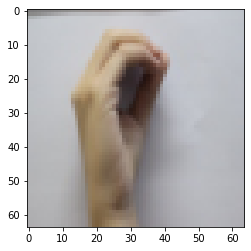

In [10]:
show_example(*dataset[5])

In [11]:
random_seed = 32
torch.manual_seed(random_seed);

In [12]:
val_size = int(0.1*len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1856, 206)

In [13]:
print(train_size)
test_size=50
train_size = len(train_ds) - test_size

train_ds, test_ds = random_split(train_ds, [train_size, test_size])
len(train_ds), len(test_ds)

1856


(1806, 50)

In [14]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [15]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
class SignLangCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 32X32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

            nn.Flatten(), 
            nn.Linear(16384, 8192),
            nn.ReLU(),
            nn.Linear(8192, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [18]:
model = SignLangCnnModel()
model

SignLangCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=16384, out_features=8192, bias=True)
    (17): ReLU()
    (18): Linear(in_features=8192, out_featur

In [19]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 64, 64])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0073, -0.0094, -0.0086, -0.0115,  0.0069, -0.0118, -0.0119,  0.0333,
        -0.0037, -0.0247], grad_fn=<SelectBackward>)


In [20]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [23]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
model = to_device(SignLangCnnModel(), device)

In [25]:
evaluate(model, val_dl)

{'val_loss': 2.3035664558410645, 'val_acc': 0.10194174945354462}

In [26]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.0001

In [29]:
import jovian

<IPython.core.display.Javascript object>

In [30]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: Â·Â·Â·Â·Â·Â·Â·Â·
[jovian] Hyperparams logged.


In [31]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.3053, val_loss: 2.3037, val_acc: 0.1019
Epoch [1], train_loss: 2.3026, val_loss: 2.3040, val_acc: 0.1019
Epoch [2], train_loss: 2.3018, val_loss: 2.3009, val_acc: 0.1019
Epoch [3], train_loss: 2.2370, val_loss: 2.0497, val_acc: 0.2913
Epoch [4], train_loss: 1.4980, val_loss: 1.1751, val_acc: 0.5485
Epoch [5], train_loss: 1.0295, val_loss: 0.9585, val_acc: 0.6699
Epoch [6], train_loss: 0.7727, val_loss: 0.7071, val_acc: 0.7476
Epoch [7], train_loss: 0.6313, val_loss: 0.5846, val_acc: 0.8010
Epoch [8], train_loss: 0.5192, val_loss: 0.6083, val_acc: 0.8010
Epoch [9], train_loss: 0.4098, val_loss: 0.4822, val_acc: 0.8495
Epoch [10], train_loss: 0.3264, val_loss: 0.3790, val_acc: 0.8689
Epoch [11], train_loss: 0.2776, val_loss: 0.3770, val_acc: 0.8689
Epoch [12], train_loss: 0.2386, val_loss: 0.3078, val_acc: 0.8786
Epoch [13], train_loss: 0.2354, val_loss: 0.3080, val_acc: 0.8981
Epoch [14], train_loss: 0.1802, val_loss: 0.2370, val_acc: 0.9029
Epoch [15], train_lo

In [32]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


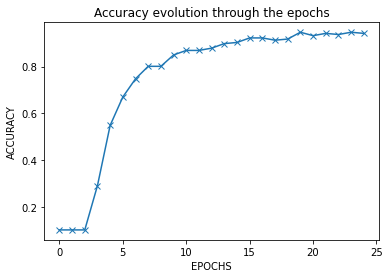

In [34]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('EPOCHS')
    plt.ylabel('ACCURACY')
    plt.title('Accuracy evolution through the epochs');
plot_accuracies(history)

In [37]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('EPOCHS')
    plt.ylabel('LOSS')
    plt.legend(['Train', 'Validate'])
    plt.title('Loss evolution through the epochs');

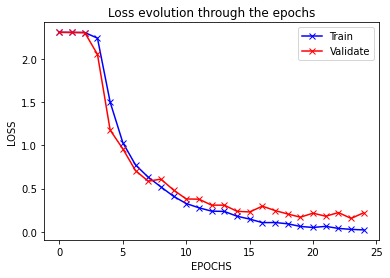

In [38]:
plot_losses(history)

In [39]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: 6 , Predicted: 6


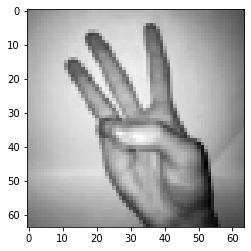

In [40]:
img, label = test_ds[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 1


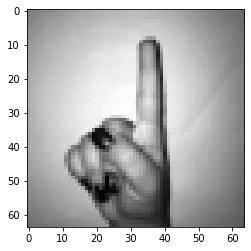

In [41]:
img, label = test_ds[1]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 3 , Predicted: 3


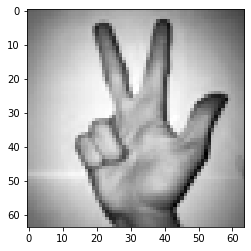

In [42]:
img, label = test_ds[2]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 4 , Predicted: 4


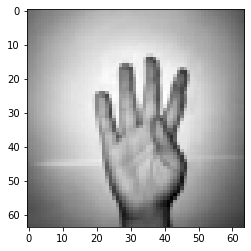

In [43]:
img, label = test_ds[4]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [44]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.06492007523775101, 'val_acc': 0.9800000190734863}

In [45]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Metrics logged.


In [46]:
project_name = 'final-project-handsign-detection'

In [47]:
import jovian

In [48]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/nicolamontori/final-project-handsign-detection


<IPython.core.display.Javascript object>